In [75]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import datetime
import time
import timestring
import math
import scipy
import scipy.sparse
import seaborn as sns

In [76]:
#import the 2017 Data and clean it
df = pd.read_csv('./Data/2017NEW.csv')

#remove rows will null values which is approximately 1.5%
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

df = df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

df = df.fillna(0)

In [77]:
df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'FL_TIME', 'FL_TIME_NEW', 'combined', 'precip'],
      dtype='object')

In [78]:
#Let's remove the features that will not be available for predicting flights
df = df[['MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER', 'ORIGIN', 
         'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 
         'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY', 'precip']]
df = df.reindex()

In [79]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,precip
0,3,21,2,2017-03-21 00:00:00,B6,BOS,MA,DCA,VA,399.0,1015,1151,3.0,0.0
1,3,21,2,2017-03-21 00:00:00,B6,IAD,VA,BOS,MA,413.0,1435,1602,-29.0,0.0
2,3,21,2,2017-03-21 00:00:00,B6,BOS,MA,IAD,VA,413.0,1215,1352,-14.0,0.0
3,3,21,2,2017-03-21 00:00:00,B6,BOS,MA,PHL,PA,280.0,804,936,-11.0,0.0
4,3,21,2,2017-03-21 00:00:00,B6,FLL,FL,BDL,CT,1173.0,1045,1342,-15.0,0.0


In [80]:
#create a list with top 20 airport origins
top_20 = list(df.groupby('ORIGIN').size().sort_values(ascending=False)[0:20].index)

In [81]:
top_5 = list(df.groupby('OP_CARRIER').size().sort_values(ascending=False)[0:5].index)

## Feature Engineering

#### Distance

In [82]:
#let's do a log transformation on the Distance feature
df['LOG_DIST'] = np.log(df.DISTANCE)

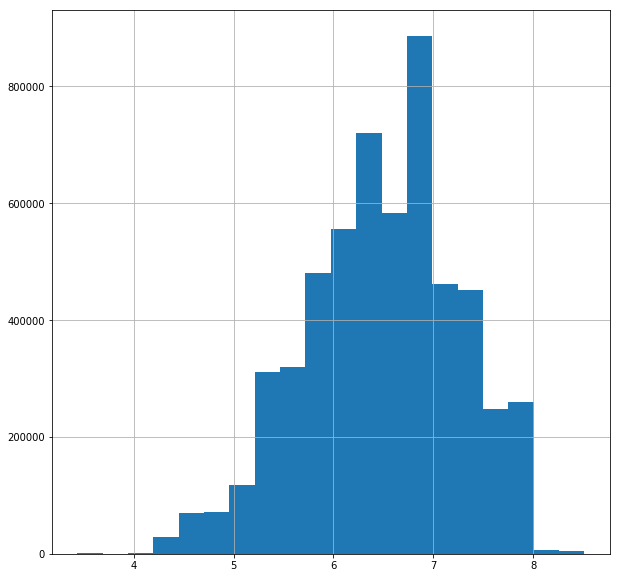

In [83]:
df.LOG_DIST.hist(bins=20)

In [84]:
#now we can bin the log distance feature into 3 catagories = short = 1, medium = 2, long = 3
df['DIST_BINS'] = pd.cut(df.LOG_DIST, bins=3, labels= [1,2,3])

In [85]:
df['DIST_BINS'] = pd.factorize(df.DIST_BINS)[0]
#clean up by dropping the original columns
df = df.drop(columns=['LOG_DIST', 'DISTANCE'])

#### Hourly bins

In [86]:
#Let's convert the DEP_TIME and ARR_TIME into hours only. 
df['ARR_HOUR'] = df['CRS_ARR_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x==24 else x)
df['DEP_HOUR'] = df['CRS_DEP_TIME'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df = df.drop(columns=['CRS_DEP_TIME', 'CRS_ARR_TIME'])

#### Direction of flight (E to W / N to S and vice versa)

In [87]:
#let's add a direction of flight features
#import airport location information csv
airport_location = pd.read_csv('airport_loc.csv')
#combine Latitude and Longitude into a tuple and form a new column and drop the Latitude & Longitude columns
airport_location['location'] = list(zip(airport_location.Latitude, airport_location.Longitude))
airports_locs = airport_location.copy()
airports_locs.head()
airports_locs.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
airport_loc = airports_locs.set_index('locationID').to_dict()['location']

#create two new columns with location coordinates of origin and destination airports
df['ORIGIN_LOC'] = df.ORIGIN.apply(lambda x: airport_loc.get(x))
df['DEST_LOC'] = df.DEST.apply(lambda x: airport_loc.get(x))

#turn into an array so we can subtract and determine which direction the plane is traveling
df.ORIGIN_LOC = df.ORIGIN_LOC.apply(lambda x: np.asarray(x))
df.DEST_LOC = df.DEST_LOC.apply(lambda x: np.asarray(x))
df['DIRECTION'] = df.ORIGIN_LOC - df.DEST_LOC

df = df.dropna(subset=['DIRECTION'])
#(n/s - increasing to the north : e/w - increasing to the west)
# if first number is negative = south - north = plane is going north
# if second number is negative = east - west = plane is going west
df['NORTH'] = df.DIRECTION.apply(lambda x: 'North' if x[0] < 0 else 'South')
df['WEST'] = df.DIRECTION.apply(lambda x: 'West' if x[1] < 0 else 'East')

#clean up and delete the columns created for this tranformation
df = df.drop(columns=['ORIGIN_LOC', 'DEST_LOC', 'DIRECTION'])

#### Is it a weekend flight or not

In [88]:
#create a weekend column
df['WEEKEND'] = df.DAY_OF_WEEK.apply(lambda x: 1 if x > 5 else 0)

#### Pick top 20 airports and top 5 airlines

In [89]:
#only use top 20 origin airports
top_df = df[df.ORIGIN.isin(top_20)]

In [90]:
#only use top 5 airlines
top_df = top_df[top_df.OP_CARRIER.isin(top_5)]

#### Weather

https://mesonet.agron.iastate.edu/ASOS/

Weather data has been pre-processed in a seperate notebook and imported in the flight dataset

In [267]:
'''#we can split the dataframes into months to remove seasonal variability
jan_df = df[df.MONTH == 1]
feb_df = df[df.MONTH == 2]
mar_df = df[df.MONTH == 3]
apr_df = df[df.MONTH == 4]
may_df = df[df.MONTH == 5]
jun_df = df[df.MONTH == 6]
jul_df = df[df.MONTH == 7]
aug_df = df[df.MONTH == 8]
sep_df = df[df.MONTH == 9]
oct_df = df[df.MONTH == 10]
nov_df = df[df.MONTH == 11]
dec_df = df[df.MONTH == 12]'''

#### Status (Delayed or Ontime)

In [91]:
#Add a column classifying if the flight is delayed or not using 20 minutes as delayed
top_df['STATUS'] = top_df.ARR_DELAY.apply(lambda x: 1 if x >= 20 else 0)

# Creating X matrix

In [92]:
name = top_df

In [93]:
name.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,ARR_DELAY,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS
8950,3,1,3,2017-03-01 00:00:00,OO,ORD,IL,MSN,WI,61.0,0.01,2,17,16,North,West,0,1
8952,3,1,3,2017-03-01 00:00:00,OO,ORD,IL,MSN,WI,4.0,0.00,2,12,12,North,West,0,0
8953,3,1,3,2017-03-01 00:00:00,OO,ORD,IL,FWA,IN,11.0,0.00,2,20,18,South,East,0,0
8955,3,1,3,2017-03-01 00:00:00,OO,ORD,IL,GRR,MI,27.0,0.00,2,10,8,North,East,0,1
8957,3,1,3,2017-03-01 00:00:00,OO,ORD,IL,BMI,IL,57.0,0.00,2,16,15,South,West,0,1


In [94]:
name.STATUS.value_counts()

0    2070522
1     380290
Name: STATUS, dtype: int64

In [39]:
down = name[name.STATUS == 1]
up = name[name.STATUS == 0]

In [40]:
down = down.OP_CARRIER.count()
up = up.OP_CARRIER.count()

In [41]:
print(f'Delay percentage: {down/(up+down)}')

Delay percentage: 0.15570207491122834


In [42]:
from sklearn.utils import resample

In [117]:
'''# Separate majority and minority classes
df_majority = name[name.STATUS==0]
df_minority = name[name.STATUS==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=up,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.STATUS.value_counts()'''

1    551763
0    551763
Name: STATUS, dtype: int64

In [43]:
#let's first separate majority class and minority class and resample

df_majority = name[name.STATUS == 0]
df_minority = name[name.STATUS == 1]


# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=down,     # to match minority class
                                 random_state=42) # reproducible results
# combine the new dataframes
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.STATUS.value_counts()

1    730788
0    730788
Name: STATUS, dtype: int64

In [44]:
name = df_downsampled

In [95]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### LabelEncoder

In [96]:
le = LabelEncoder()
name['OP_CARRIER'] = le.fit_transform(name.OP_CARRIER.values)
name['ORIGIN'] = le.fit_transform(name.ORIGIN.values)
name['DEST'] = le.fit_transform(name.DEST.values)
name['NORTH'] = le.fit_transform(name.NORTH.values)
name['WEST'] = le.fit_transform(name.WEST.values)
name['ORIGIN_SATE_ABR'] = le.fit_transform(name.ORIGIN_STATE_ABR.values)
name['DEST_SATE_ABR'] = le.fit_transform(name.DEST_STATE_ABR.values)

# Random Forrest

Original run is on the entire 2017 dataset, with no feature engineering, only encoding departure and arrival hour blocks: Accuracy=82.5% AUC=0.738 with n_estimators=100.

Features to add: Seperater the data by month, log_distance, direction of flight (S to N & E to W), cluster regions of origin, cluster regions of arrival (West, South, Midwest, East), upsample or downsample to remove imbalance. 

In [97]:
name.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'ARR_DELAY',
       'precip', 'DIST_BINS', 'ARR_HOUR', 'DEP_HOUR', 'NORTH', 'WEST',
       'WEEKEND', 'STATUS', 'ORIGIN_SATE_ABR', 'DEST_SATE_ABR'],
      dtype='object')

In [98]:
name.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,ARR_DELAY,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS,ORIGIN_SATE_ABR,DEST_SATE_ABR
8950,3,1,3,2017-03-01 00:00:00,2,15,IL,176,WI,61.0,0.01,2,17,16,0,1,0,1,5,48
8952,3,1,3,2017-03-01 00:00:00,2,15,IL,176,WI,4.0,0.00,2,12,12,0,1,0,0,5,48
8953,3,1,3,2017-03-01 00:00:00,2,15,IL,95,IN,11.0,0.00,2,20,18,1,0,0,0,5,13
8955,3,1,3,2017-03-01 00:00:00,2,15,IL,103,MI,27.0,0.00,2,10,8,0,0,0,1,5,20
8957,3,1,3,2017-03-01 00:00:00,2,15,IL,28,IL,57.0,0.00,2,16,15,1,1,0,1,5,12


In [99]:
#initial run
rand = name.drop(columns=['FL_DATE', 'ARR_DELAY',
                         'ORIGIN_STATE_ABR', 'DEST_STATE_ABR'])

In [100]:
#rand = name.drop(columns=['ARR_DELAY', 'DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'LOG_DIST',
#                         'ORIGIN_LOC', 'DEST_LOC', 'DIRECTION'])

In [101]:
rand.STATUS.value_counts()

0    2070522
1     380290
Name: STATUS, dtype: int64

In [102]:
rand.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS,ORIGIN_SATE_ABR,DEST_SATE_ABR
8950,3,1,3,2,15,176,0.01,2,17,16,0,1,0,1,5,48
8952,3,1,3,2,15,176,0.00,2,12,12,0,1,0,0,5,48
8953,3,1,3,2,15,95,0.00,2,20,18,1,0,0,0,5,13
8955,3,1,3,2,15,103,0.00,2,10,8,0,0,0,1,5,20
8957,3,1,3,2,15,28,0.00,2,16,15,1,1,0,1,5,12


In [103]:
rand = rand.fillna(0)

In [104]:
y = rand.STATUS.values
X = rand.drop(columns='STATUS').values

In [105]:
cols = rand.drop(columns='STATUS').columns

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [107]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [122]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rand=RandomForestClassifier(n_estimators=100)

In [123]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rand.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [124]:
y_pred = clf_rand.predict(X_test)

In [125]:
# Model Accuracy, how often is the classifier correct?
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.855111462921518


In [126]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[403767,  10126],
       [ 60893,  15377]])

In [127]:
from sklearn.metrics import f1_score

In [128]:
f1_score(y_test, y_pred, average='weighted')

0.8231605681844844

In [129]:
#find important features
feature_imp = pd.Series(clf_rand.feature_importances_,index=cols).sort_values(ascending=False)
feature_imp

DAY_OF_MONTH       0.274250
MONTH              0.125879
DEST               0.109784
DAY_OF_WEEK        0.098912
DEP_HOUR           0.073403
ARR_HOUR           0.073395
DEST_SATE_ABR      0.065638
ORIGIN             0.037768
ORIGIN_SATE_ABR    0.034622
OP_CARRIER         0.031670
precip             0.026114
DIST_BINS          0.014697
NORTH              0.013968
WEST               0.012286
WEEKEND            0.007615
dtype: float64

In [130]:
y_prob = clf_rand.predict_proba(X_test)[::,1]

In [131]:
y_prob

array([0.09, 0.03, 0.1 , ..., 0.09, 0.01, 0.7 ])

In [132]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

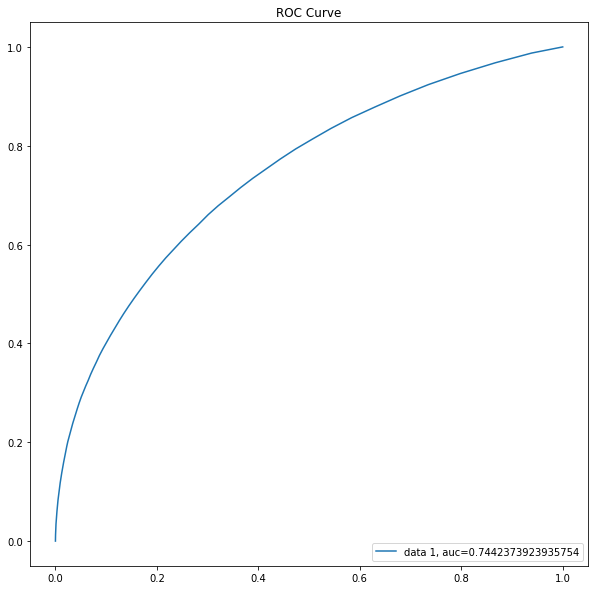

In [133]:
y_pred_proba = y_prob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [134]:
rand.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS,ORIGIN_SATE_ABR,DEST_SATE_ABR
8950,3,1,3,2,15,176,0.01,2,17,16,0,1,0,1,5,48
8952,3,1,3,2,15,176,0.00,2,12,12,0,1,0,0,5,48
8953,3,1,3,2,15,95,0.00,2,20,18,1,0,0,0,5,13
8955,3,1,3,2,15,103,0.00,2,10,8,0,0,0,1,5,20
8957,3,1,3,2,15,28,0.00,2,16,15,1,1,0,1,5,12


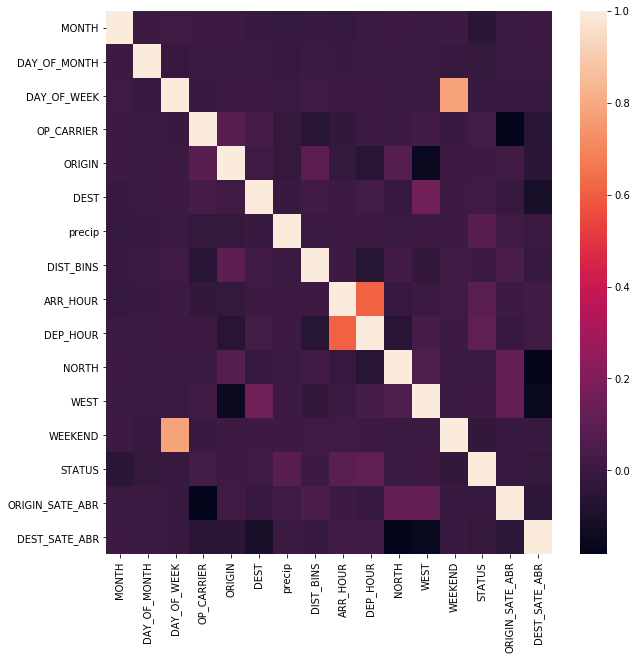

In [135]:
corr_matrix = rand.corr()
sns.heatmap(corr_matrix)
plt.show()

### OneHotEncoder

In [117]:
objects = ['OP_CARRIER', 'ORIGIN', 'DEST']
dates = ['DAY_OF_MONTH', 'DAY_OF_WEEK']
hours = ['ARR_HOUR', 'DEP_HOUR']
dist = ['DIST_BINS', 'NORTH', 'WEST']

In [118]:
enc = OneHotEncoder(handle_unknown='ignore')
dates_matrix = enc.fit_transform(name[dates].values)
objects_matrix = enc.fit_transform(name[objects].values)
hour_matrix = enc.fit_transform(name[hours].values)
dist_matrix = enc.fit_transform(name[dist].values)

In [119]:
print(f'Size is: {dates_matrix.data.nbytes / 1000000} MB')
print(f'Size is: {objects_matrix.data.nbytes / 1000000} MB')
print(f'Size is: {hour_matrix.data.nbytes / 1000000} MB')
print(f'Size is: {dist_matrix.data.nbytes / 1000000} MB')

Size is: 49.377696 MB
Size is: 74.066544 MB
Size is: 49.377696 MB
Size is: 74.066544 MB


In [120]:
from scipy.sparse import hstack
X_final = hstack((dates_matrix, objects_matrix, hour_matrix, dist_matrix))
X_final_lr = hstack((dates_matrix, objects_matrix, hour_matrix))

In [121]:
print(f'Size is: {X_final.data.nbytes / 1000000} MB')

Size is: 246.88848 MB


## Linear Regression

In [839]:
y = name.ARR_DELAY
y_r = y.values
y_r = y_r.reshape(-1,1)

In [840]:
X_r = X_final_lr

In [841]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [842]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size = 0.2, random_state=42)

In [843]:
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [844]:
y_pred = reg_all.predict(X_test)

In [845]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.06370262450381714
Root Mean Squared Error: 44.138071867203784


This looks like a pretty bad model. Let's see why...

In [846]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

(4, 7)

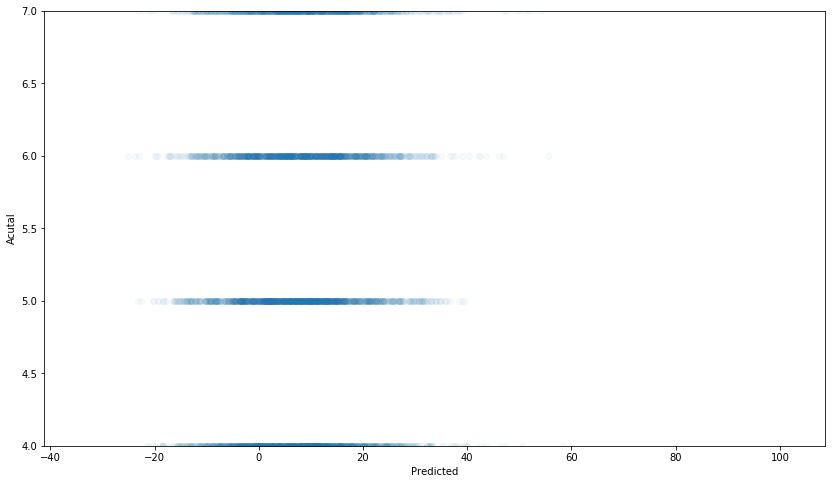

In [847]:
plt.scatter(y_pred, y_test, alpha=0.03)
plt.xlabel('Predicted')
plt.ylabel('Acutal')
plt.ylim(4,7)

   # Using Cross Validation

In [188]:
from sklearn.model_selection import cross_val_score

In [189]:
cv_scores = cross_val_score(reg_all, X_final, y_final, cv=5)
print(cv_scores)

[0.09811053 0.11849466 0.08445649 0.06708186 0.10895339]


Other possible models:

# SGD Regressor

# SGD Classifier - Will the flight be delayed or not, and probability

# Logistic Regression - Will the flight be delayed or not, and probability

In [113]:
name.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,LOG_DIST,DIST_BINS,ARR_HOUR,DEP_HOUR,ORIGIN_LOC,DEST_LOC,DIRECTION,NORTH,WEST,STATUS
0,3,21,2,2,1,75,399.0,1015,1151,3.0,5.988961,0,11,10,"[42.3631, 71.0064]","[38.8522, 77.0378]","[3.5108999999999995, -6.031400000000005]",1,1,0
2,3,21,2,2,1,133,413.0,1215,1352,-14.0,6.023448,0,13,12,"[42.3631, 71.0064]","[38.9475, 77.46]","[3.415600000000005, -6.4535999999999945]",1,1,0
3,3,21,2,2,1,220,280.0,804,936,-11.0,5.634790,0,9,8,"[42.3631, 71.0064]","[39.8722, 75.2408]","[2.4909000000000034, -4.234399999999994]",1,1,0
5,3,21,2,2,12,216,1035.0,730,1032,-32.0,6.942157,1,10,7,"[40.7772, 73.8725]","[26.6832, 80.0956]","[14.094000000000001, -6.223100000000002]",1,1,0
7,3,21,2,2,1,246,1249.0,600,933,-16.0,7.130099,1,9,6,"[42.3631, 71.0064]","[26.5362, 81.7553]","[15.826900000000002, -10.748900000000006]",1,1,0


In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [115]:
name.groupby('STATUS').size()

STATUS
0    2581012
1     505094
dtype: int64

In [116]:
y=name.STATUS.values

In [122]:
X=X_final

In [123]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=0.3, random_state=5)

In [124]:
clf = LogisticRegression(solver='liblinear')

In [125]:
clf.fit(Xlr, ylr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [126]:
y_pred = clf.predict(Xtestlr)

In [127]:
print(accuracy_score(y_pred, ytestlr))

0.8362564698563022


In [819]:
from sklearn.model_selection import KFold

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [820]:
clf = LogisticRegression(solver='liblinear')
score = cv_score(clf, Xlr, ylr)
print(score)

0.7974916138441207


In [128]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(ytestlr, y_pred)
cnf_matrix

array([[773893,    309],
       [151290,    340]])

In [129]:
print("Accuracy:",metrics.accuracy_score(ytestlr, clf.predict(Xtestlr)))
print("Precision:",metrics.precision_score(ytestlr, clf.predict(Xtestlr)))
print("Recall:",metrics.recall_score(ytestlr, clf.predict(Xtestlr)))

Accuracy: 0.8362564698563022
Precision: 0.5238828967642527
Recall: 0.0022423003363450504


In [130]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

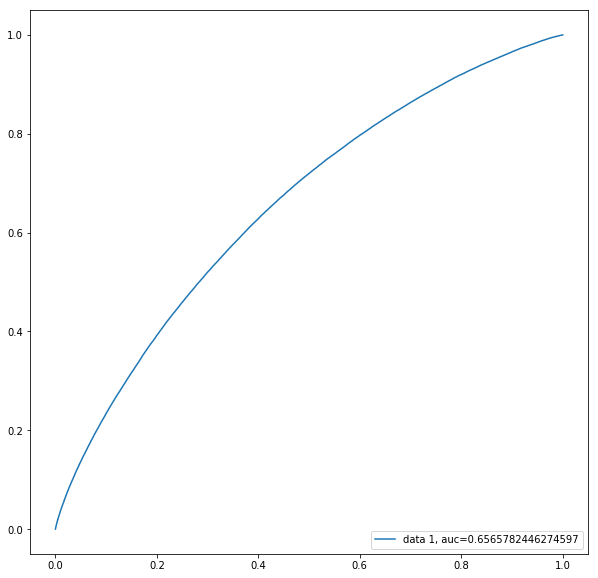

In [131]:
y_pred_proba = clf.predict_proba(Xtestlr)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytestlr,  y_pred_proba)
auc = metrics.roc_auc_score(ytestlr, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Naive Bayes

In [292]:
name.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_CARRIER',
       'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'ARR_DELAY',
       'precip', 'DIST_BINS', 'ARR_HOUR', 'DEP_HOUR', 'NORTH', 'WEST',
       'WEEKEND', 'STATUS', 'ORIGIN_SATE_ABR', 'DEST_SATE_ABR'],
      dtype='object')

In [291]:
name.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,...,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS,ORIGIN_SATE_ABR,DEST_SATE_ABR
16,2017,3,21,2,2017-03-21 00:00:00,0,1,MA,70,TX,...,0.0,1,13,10,1,1,0,0,6,42
17,2017,3,21,2,2017-03-21 00:00:00,0,1,MA,70,TX,...,0.0,1,13,10,1,1,0,0,6,42
18,2017,3,21,2,2017-03-21 00:00:00,0,1,MA,188,IL,...,0.0,0,12,10,1,1,0,0,6,12
19,2017,3,21,2,2017-03-21 00:00:00,0,1,MA,188,IL,...,0.0,0,12,10,1,1,0,0,6,12
20,2017,3,21,2,2017-03-21 00:00:00,0,1,MA,53,NC,...,0.0,0,13,10,1,1,0,0,6,25


In [293]:
bayes = name.drop(columns=['YEAR', 'FL_DATE', 'ARR_DELAY',
                         'ORIGIN_STATE_ABR', 'DEST_STATE_ABR'])

In [294]:
bayes.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,precip,DIST_BINS,ARR_HOUR,DEP_HOUR,NORTH,WEST,WEEKEND,STATUS,ORIGIN_SATE_ABR,DEST_SATE_ABR
16,3,21,2,0,1,70,0.0,1,13,10,1,1,0,0,6,42
17,3,21,2,0,1,70,0.0,1,13,10,1,1,0,0,6,42
18,3,21,2,0,1,188,0.0,0,12,10,1,1,0,0,6,12
19,3,21,2,0,1,188,0.0,0,12,10,1,1,0,0,6,12
20,3,21,2,0,1,53,0.0,0,13,10,1,1,0,0,6,25


In [295]:
y = bayes.STATUS.values
#X = X_final
#X = X.toarray()
X = bayes.drop(columns='STATUS').values

In [296]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [297]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [298]:
#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [299]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8412891858003774


In [300]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[783466,   9061],
       [139921,   6253]])

In [301]:
y_prob = gnb.predict_proba(X_test)[::,1]

In [302]:
y_prob

array([0.06247596, 0.04536547, 0.03828639, ..., 0.10773575, 0.01074158,
       0.09107639])

In [303]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

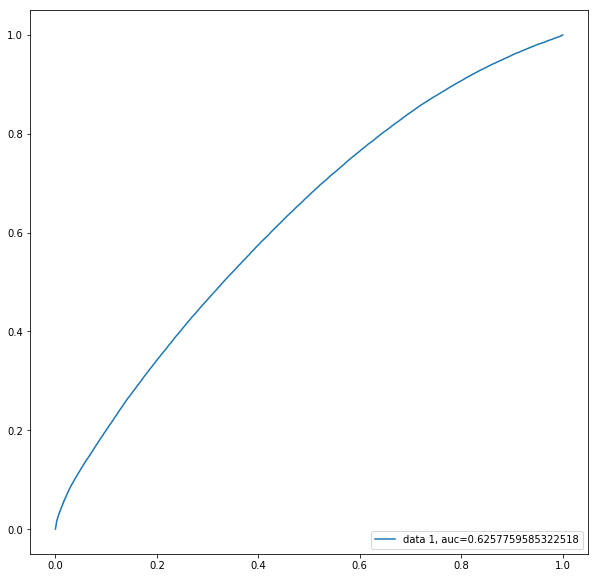

In [304]:
y_pred_proba = y_prob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()